# feature engineering

### setup

In [1]:
THRESHOLD=0.2
PROP=1/100

#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


## demographics
From admissions and patients tables

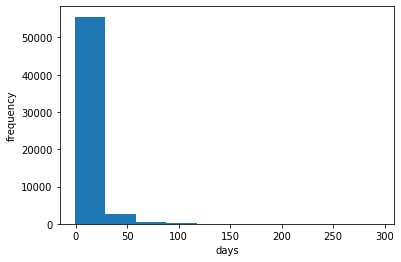

In [2]:
#load admission data along with outcomes desginated in build_outcome.ipynb
adat = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/outcome_penalizable_dat.csv')

#add stay duration
adat['stay_duration'] = pd.to_datetime(adat['dischtime']) - pd.to_datetime(adat['admittime'])
adat['stay_duration'] = pd.to_timedelta(adat['stay_duration'], unit='D')/datetime.timedelta(days=1)
plt.hist(adat['stay_duration'])
plt.xlabel('days')
plt.ylabel('frequency');

#subset for useful variables and remove patients with deathtimes
adat = adat.loc[adat['deathtime'].isna(), ['subject_id', 'hadm_id', 'admittime', 'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'hospital_expire_flag', 'stay_duration', 'hrrd_penalized']]

In [3]:
#load patient data
query = query_schema + \
"""select 
    subject_id,
    gender,
    dob
    from patients"""
pdat = pd.read_sql_query(query,con)

#merge them
odat = pd.merge(adat, pdat, how = 'inner', on='subject_id')
odat['dob_dt'] = pd.to_datetime(odat['dob']).dt.date
odat['admittime_dt'] = pd.to_datetime(odat['admittime']).dt.date
odat['age'] = odat.apply(lambda e: (e['admittime_dt'] - e['dob_dt']).days/365, axis=1)
odat.loc[odat['age']>200, 'age'] = 91
odat = odat.loc[odat['age']>18, ['subject_id', 'hadm_id', 'hrrd_penalized', 'discharge_location', 'insurance',
       'language', 'religion', 'marital_status', 'ethnicity',
       'gender', 'age']]
odat.index = odat['hadm_id']
odat.drop(columns = ['hadm_id', 'subject_id'])

hrrd_penalized         discharge_location insurance language  \
hadm_id                                                                 
165315                0  DISC-TRAN CANCER/CHLDRN H   Private      NaN   
152223                0           HOME HEALTH CARE  Medicare      NaN   
124321                0           HOME HEALTH CARE  Medicare     ENGL   
161859                0                       HOME   Private      NaN   
129635                0                       HOME   Private      NaN   
...                 ...                        ...       ...      ...   
141860                0                        SNF  Medicare     ENGL   
187987                0           HOME HEALTH CARE   Private     ENGL   
190603                0           HOME HEALTH CARE  Medicare     ENGL   
191113                0                       HOME   Private     ENGL   
122631                0           HOME HEALTH CARE   Private     ENGL   

                  religion marital_status ethnicity gender        age  
hadm_id                                                                
165315        UNOBTAINABLE        MARRIED     WHITE      F  64.969863  
152223            CATHOLIC        MARRIED     WHITE      M  71.178082  
124321            CATHOLIC        MARRIED     WHITE      M  75.304110  
161859   PROTESTANT QUAKER         SINGLE     WHITE      M  39.041096  
129635        UNOBTAINABLE        MARRIED     WHITE      M  58.989041  
...                    ...            ...       ...    ...        ...  
141860            CATHOLIC        WIDOWED     WHITE      F  80.389041  
187987       NOT SPECIFIED        MARRIED     WHITE      M  53.613699  
190603            CATHOLIC        MARRIED     WHITE      M  78.326027  
191113       NOT SPECIFIED         SINGLE     WHITE      F  19.410959  
122631       NOT SPECIFIED        MARRIED     WHITE      M  42.558904  

[44987 rows x 9 columns]

#### handle missing values

In [4]:
# print(np.sum(odat.isnull()))
odat.loc[odat['language'].isna(), 'language'] = 'missing'
odat.loc[odat['religion'].isna(), 'religion'] = 'missing'
odat.loc[odat['marital_status'].isna(), 'marital_status'] = 'missing'
# print(np.sum(odat.isnull()))

#### age distribution

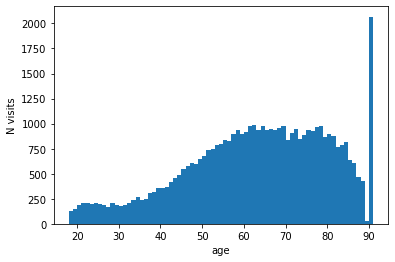

In [5]:
plt.hist(odat['age'], bins = 91-18);
plt.xlabel('age')
plt.ylabel('N visits')
plt.show();

### add icu features
add total time spent in icu and total icu visits

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


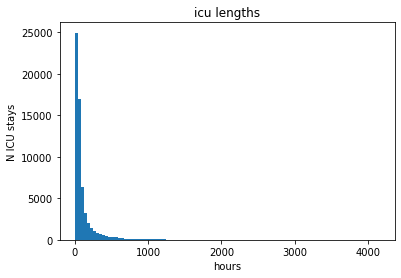

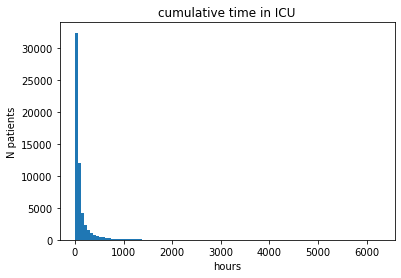

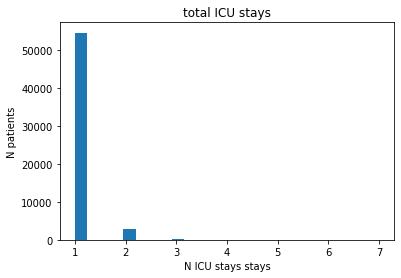

In [6]:
#load patient data
query = query_schema + \
"""select 
    *
    from ICUSTAYS"""
idat = pd.read_sql_query(query,con)



idat['icu_duration'] = idat['outtime'] - idat['intime']
idat['icu_duration'] = pd.to_timedelta(idat['icu_duration'], unit='hr')/datetime.timedelta(hours=1)

#plot icu hours
plt.hist(idat['icu_duration'], bins=100)
plt.title('icu lengths')
plt.xlabel('hours')
plt.ylabel('N ICU stays')
plt.show()

#organize icu stay features
total_time = idat.loc[:,['icu_duration', 'hadm_id']].groupby(['hadm_id']).sum()
total_icu_visits = idat.loc[:,['hadm_id', 'icustay_id']].groupby(['hadm_id']).count()
total_icu_visits.columns = ['nicu_stays']
total_icu_visits.index.name = 'hadm_id'
icu_features = pd.merge(total_time, total_icu_visits, how='inner', on='hadm_id')

#plot cumulative icu time
plt.hist(icu_features['icu_duration'], bins=100)
plt.title('cumulative time in ICU')
plt.xlabel('hours')
plt.ylabel('N patients')
plt.show()

#plot total ICU stays
plt.hist(icu_features['nicu_stays'], bins=25)
plt.title('total ICU stays')
plt.xlabel('N ICU stays stays')
plt.ylabel('N patients')
plt.show()

#add to odat
odat = pd.merge(odat.drop(columns='hadm_id'), icu_features, how = 'inner', on = 'hadm_id')

In [7]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

odat['hadm_id'] = odat.index
y = odat['hrrd_penalized']
X = odat.drop([
    'hrrd_penalized'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=321, stratify=y)
print(np.sum(y_train))
print(np.sum(y_test))
all_hadm_ids = odat['hadm_id']
train_hadm_ids = X_train['hadm_id']
test_hadm_ids = X_test['hadm_id']
train_pos_hadm_ids = train_hadm_ids[y==1]
len(train_pos_hadm_ids)
X_train.drop(['subject_id', 'hadm_id'], 1)
X_test.drop(['subject_id', 'hadm_id'], 1)

#write out outcomes
import joblib
joblib.dump(y_train, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib')

908
227


['/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib']

## Funcitons for feature selection

In [8]:
def filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop=1/50):
    """Function to remove features unlikely to be informative for outcome.
    df = the input predictors
    pos_ids = the positive hadm_ids
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of positive patients the feature must have occured in to keep it"""
    pos_df = input_df.loc[input_df['hadm_id'].isin(pos_ids),]
    occurance = pos_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(pos_ids)*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]


def filter_by_presence_in_general(input_df, feature_col, prop=1/100):
    """Function to remove features unlikely to be informative for outcome because rare in dataset.
    input_df = the input predictors
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of hadm_ids the feature must have occured in to keep it"""
    occurance = input_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(input_df['hadm_id'].unique())*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]

from sklearn.preprocessing import MinMaxScaler
def onehot_features(long_df, feature_col):
    to_onehot = [feature_col]
    raw_oh_dat = pd.get_dummies(long_df, columns = to_onehot, drop_first = True)
    summed_dat = raw_oh_dat.groupby('hadm_id').sum()
    bool_dat = summed_dat > 0
    oh_dat = bool_dat.astype('int')
    total_col = 'total_{}'.format(feature_col)
    oh_dat[total_col] = oh_dat.sum(axis=1)
    scaler = MinMaxScaler()
    oh_dat[[total_col]] = scaler.fit_transform(oh_dat[[total_col]])
    return oh_dat

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
def logistic_select_features(dat, y_train, feature_col, threshold):
    """feature selection using l1 regularization.
    dat = full dataset of features
    y_train = the training outcome data indexed with hadm_id
    The data are subset to match just the test set, then logistic regression coefficient is used for selection"""
    #make sure data and training outputs line up
    dat_for_train = dat.copy()
    dat_ids = set(dat_for_train.index)
    y_ids = set(y_train.index)
    shared_ids = list(dat_ids.intersection(y_ids))
    dat_X_train = dat_for_train.loc[shared_ids,:] #first subset for training set
    dat_y_train = y_train.loc[shared_ids]   #then subset outcomes to match
    matched = np.sum(dat_X_train.index==dat_y_train.index) ==dat_X_train.shape[0]
    print('training data and outcomes matched = {}'.format(matched))
    print('total ids used for training = {}'.format(dat_X_train.shape[0]))
    #do selection
    sel = SelectFromModel(estimator=LogisticRegression(max_iter=1000),
                         threshold = threshold).fit(dat_X_train, dat_y_train)
    coefs = sel.estimator_.coef_
    #write out for prettier plotting
    pd.DataFrame({'coef':coefs[0]}).to_csv('../data/for_plotting/' + feature_col + '_coefs.csv',
                                          index=False)
    #plot the distribution of coefficients
    plt.hist(coefs[0], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('before selection')
    plt.show()
    #plot the distribution of coefficients after selection
    plt.hist(coefs[0][sel.get_support()], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('after selection')
    plt.show()
    #make selections
    print(np.mean(np.absolute(coefs)))
    print('selector threshold = {}'.format(sel.threshold_))
    sel.get_support()
    nonZeroN = np.sum(sel.get_support())
    print('{} total featuers had nonzero coefficients after selection'.format(nonZeroN))
    res = dat.loc[:,list(dat_X_train.columns[sel.get_support()])]
    return res

#function to combine all above
def select_presence_absence_features(input_df, all_ids, train_ids, pos_ids, feature_col, prop, y_train, threshold):
    filt_pos = filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop)
    filt_gen = filter_by_presence_in_general(input_df, feature_col, prop=prop)
    keep = pd.concat([filt_pos, filt_gen], 0)
    filt_df = input_df.loc[input_df[feature_col].isin(keep[feature_col])]
    print('{} features total unique feature kept for selection'.format(len(filt_df[feature_col].unique()), prop*100))
    oh_dat = onehot_features(filt_df, feature_col)
    sel_dat = logistic_select_features(oh_dat, y_train, feature_col, threshold)
    return sel_dat

    
#vars for recording
dat_dict = {'odat': odat}
dat_list = ['odat']

## add presence absence features

## services

11 features found among >= 1.0% of positive cases
12 features found among >= 1.0% of positive cases
12 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34745


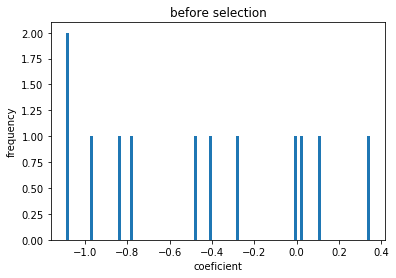

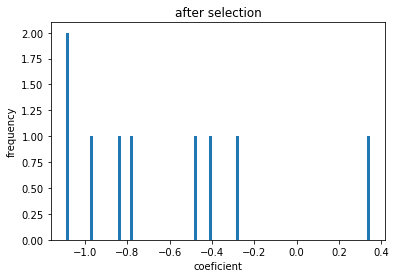

0.5323720537911941
selector threshold = 0.2
9 total featuers had nonzero coefficients after selection


(58029, 9)

In [9]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    curr_service
    from SERVICES"""
serv_dat = pd.read_sql_query(query,con)
serv_dat = select_presence_absence_features(input_df = serv_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'curr_service',
                                          prop=PROP,
                                          y_train = y_train,
                                            threshold=THRESHOLD)
dat_dict['services'] = serv_dat
dat_list.append('services')
serv_dat.shape

### diagnoses

total unique diagnoses = 6985
270 features found among >= 1.0% of positive cases
211 features found among >= 1.0% of positive cases
309 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34395


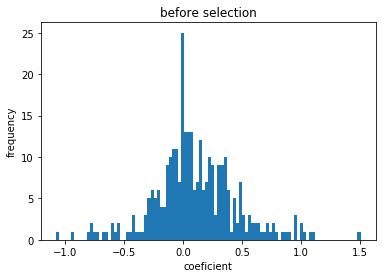

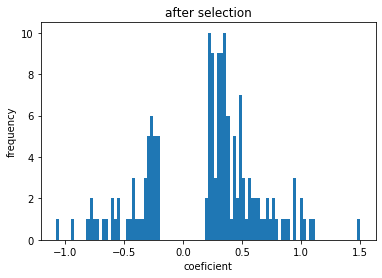

0.26636374930725687
selector threshold = 0.2
152 total featuers had nonzero coefficients after selection


(57791, 152)

In [11]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from DIAGNOSES_ICD"""
ddat = pd.read_sql_query(query,con)
ddat = ddat.rename(columns = {'icd9_code':'diagnosis_icd9'})
print('total unique diagnoses = {}'.format(len(ddat['diagnosis_icd9'].unique())))
ddat = select_presence_absence_features(input_df = ddat,
                                        all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'diagnosis_icd9',
                                          prop=PROP,
                                          y_train = y_train,
                                         threshold=THRESHOLD)
dat_dict['diagnoses'] = ddat
dat_list.append('diagnoses')
ddat.shape

### procedures

total unique diagnoses = 2032
61 features found among >= 1.0% of positive cases
72 features found among >= 1.0% of positive cases
76 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 27600


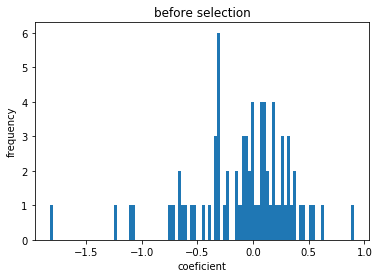

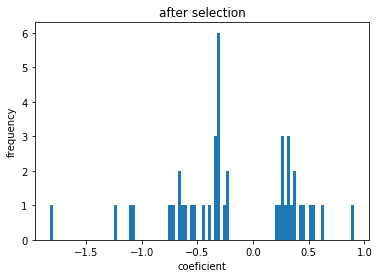

0.32496186016513123
selector threshold = 0.2
44 total featuers had nonzero coefficients after selection


(47758, 44)

In [12]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from PROCEDURES_ICD"""
proc_dat = pd.read_sql_query(query, con)
proc_dat = proc_dat.rename(columns = {'icd9_code':'procedure_icd9'})
print('total unique procedures = {}'.format(len(proc_dat['procedure_icd9'].unique())))
proc_dat = select_presence_absence_features(input_df = proc_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'procedure_icd9',
                                          prop=PROP,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
dat_dict['procedures'] = proc_dat
dat_list.append('procedures')
proc_dat.shape

### prescriptions

138 features found among >= 10.0% of positive cases
146 features found among >= 10.0% of positive cases
163 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 32360


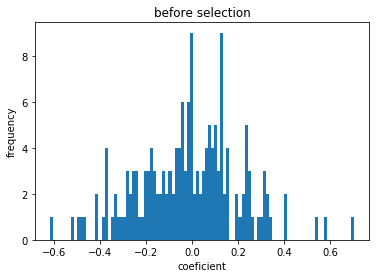

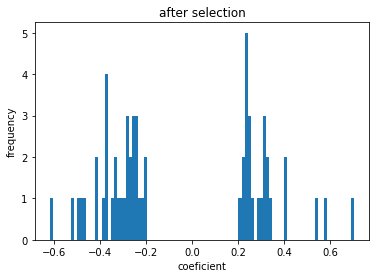

0.17199785993023745
selector threshold = 0.2
58 total featuers had nonzero coefficients after selection


(49856, 58)

In [33]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    drug
    from PRESCRIPTIONS"""
drug_dat = pd.read_sql_query(query, con)
drug_dat = select_presence_absence_features(input_df = drug_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'drug',
                                          prop=1/10,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
dat_dict['drugs'] = drug_dat
dat_list.append('drugs')
drug_dat.shape

### icu wards
Here we get all the ICU wards the pateint was exposed to

5 features found among >= 2.0% of positive cases
6 features found among >= 2.0% of positive cases
6 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 35164


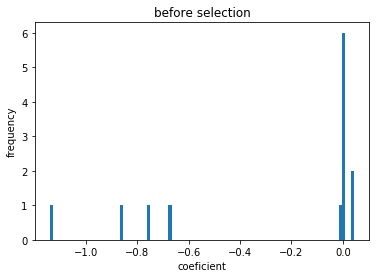

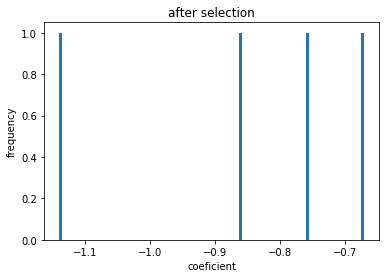

0.2718126957663292
selector threshold = 0.2
4 total featuers had nonzero coefficients after selection
9 features found among >= 2.0% of positive cases
10 features found among >= 2.0% of positive cases
10 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34925


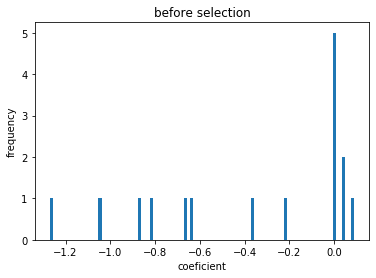

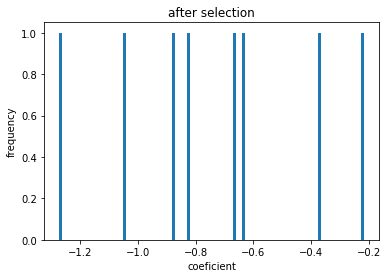

0.37885997945567956
selector threshold = 0.2
8 total featuers had nonzero coefficients after selection


In [34]:
#care unit
careunit_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_careunit',
                                          prop=1/50,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
if careunit_dat.shape[0] > 0:
    dat_dict['care_unit'] = careunit_dat
    dat_list.append('care_unit')
    careunit_dat.shape

#ward
ward_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_wardid',
                                          prop=1/50,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
if careunit_dat.shape[0] > 0:
    dat_dict['ward'] = ward_dat
    dat_list.append('ward')
    ward_dat.shape

### add discharge note features

In [35]:
ndat = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/discharge_note_features.csv', index_col='hadm_id') #build this with discharge_notes.ipynb
dat_dict['dnotes'] = ndat
dat_list.append('dnotes')

## combine

In [36]:
cdat = odat.copy()
cdat = cdat.drop(columns = ['hadm_id'])

#merge them all
for d in dat_list:
    if d != 'odat':
        to_add = dat_dict[d]
        print(d)
        cdat = pd.merge(cdat, dat_dict[d], how = 'left', on='hadm_id')

        
y = cdat['hrrd_penalized'].astype('int')
cdat = cdat.drop(['subject_id', 'hrrd_penalized'], 1)

services
diagnoses
procedures
drugs
care_unit
ward
dnotes


### missing

In [37]:
missing = cdat.isnull().sum()
cols_w_missing = missing[missing>0].index

#imput totals with mean
totals_w_missing = cols_w_missing[cols_w_missing.str.contains('total_')]
for tc in totals_w_missing:
    cdat[tc] = cdat[tc].fillna(cdat[tc].mean())

#imput the categorical cols
categorical_w_missing = cols_w_missing[~cols_w_missing.isin(totals_w_missing)]
for cc in categorical_w_missing:
    cdat[cc] = cdat[cc].fillna(0)


### onehot

In [38]:
#onehot encode the pdat columns
to_onehot = ['discharge_location', 
             'insurance', 
             'language',
             'religion', 
             'marital_status',
             'ethnicity',
            'gender']
cdat = pd.get_dummies(cdat, columns = to_onehot, drop_first = True)
cdat

age  icu_duration  nicu_stays  curr_service_CSURG  \
hadm_id                                                            
165315   64.969863     27.450000           1                 0.0   
152223   71.178082     30.337778           1                 1.0   
124321   75.304110     28.469444           1                 0.0   
161859   39.041096     12.296944           1                 0.0   
129635   58.989041     85.117778           1                 0.0   
...            ...           ...         ...                 ...   
141860   80.389041    186.932500           1                 0.0   
187987   53.613699     78.476667           2                 0.0   
190603   78.326027     54.931111           1                 1.0   
191113   19.410959     21.066667           1                 0.0   
122631   42.558904     46.852778           1                 0.0   

         curr_service_MED  curr_service_NMED  curr_service_NSURG  \
hadm_id                                                            
165315                1.0                0.0                 0.0   
152223                0.0                0.0                 0.0   
124321                0.0                0.0                 1.0   
161859                0.0                0.0                 0.0   
129635                0.0                0.0                 0.0   
...                   ...                ...                 ...   
141860                0.0                0.0                 0.0   
187987                0.0                0.0                 0.0   
190603                0.0                0.0                 0.0   
191113                0.0                0.0                 0.0   
122631                0.0                0.0                 0.0   

         curr_service_OMED  curr_service_ORTHO  curr_service_SURG  ...  \
hadm_id                                                            ...   
165315                 0.0                 0.0                0.0  ...   
152223                 0.0                 0.0                0.0  ...   
124321                 0.0                 0.0                0.0  ...   
161859                 0.0                 0.0                0.0  ...   
129635                 0.0                 0.0                0.0  ...   
...                    ...                 ...                ...  ...   
141860                 0.0                 0.0                1.0  ...   
187987                 0.0                 1.0                0.0  ...   
190603                 0.0                 0.0                0.0  ...   
191113                 0.0                 0.0                0.0  ...   
122631                 0.0                 0.0                0.0  ...   

         ethnicity_PORTUGUESE  ethnicity_SOUTH AMERICAN  \
hadm_id                                                   
165315                      0                         0   
152223                      0                         0   
124321                      0                         0   
161859                      0                         0   
129635                      0                         0   
...                       ...                       ...   
141860                      0                         0   
187987                      0                         0   
190603                      0                         0   
191113                      0                         0   
122631                      0                         0   

         ethnicity_UNABLE TO OBTAIN  ethnicity_UNKNOWN/NOT SPECIFIED  \
hadm_id                                                                
165315                            0                                0   
152223                            0                                0   
124321                            0                                0   
161859                            0                                0   
129635                            0                                0   
...       

### scale

In [39]:
#Note the 'total' columns created for presence absence sets above are already scaled
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
need_scaling = [
    'age', 'icu_duration', 'nicu_stays'
]
cdat[need_scaling] = scaler.fit_transform(cdat[need_scaling])
print('maximum value in dataframe = {}'.format(max(cdat.max())))

maximum value in dataframe = 31.0


### handle colinearity
greedily take the member of each pair that correlates better with outcome

In [40]:
#get highly correlated pairs
m = cdat.corr()
cor_df = m.stack().reset_index()
cor_df.columns = ['f1', 'f2', 'cor']
cor_df = cor_df.loc[cor_df['f1']!=cor_df['f2'],:]
hcor_df = cor_df.loc[np.abs(cor_df['cor'])>0.75,:]
sorted_pairs = pd.DataFrame(hcor_df.loc[:,['f1','f2']].apply(lambda x: x.sort_values().values, axis=1))
dups = pd.DataFrame(sorted_pairs[0].tolist(), index= sorted_pairs.index).duplicated()
hcor_df = hcor_df.loc[~dups,:]

#drop the lesser of the two
def col_outcome_cor(col):
    c = cdat[col].corr(y)
    return(c)
col_outcome_cor('curr_service_CSURG')
hcor_df['f1c'] = hcor_df['f1'].apply(col_outcome_cor)
hcor_df['f2c'] = hcor_df['f2'].apply(col_outcome_cor)
f1_higher = hcor_df['f1c'] >= hcor_df['f2c']
drop_count = 0
for i in range(len(f1_higher)):
    f1 = hcor_df.loc[hcor_df.index[i],'f1']
    f2 = hcor_df.loc[hcor_df.index[i],'f2']
    compare = f1_higher.loc[f1_higher.index[i]]
    if compare:
        to_drop = f2
    else:
        to_drop=f1
    if str(to_drop) in cdat.columns:
        cdat.drop(columns=[to_drop])
        drop_count += 1
print('{} features from {} feature pairs with correlations > 0.75 were dropped'.format(drop_count, hcor_df.shape[0]))

6 features from 6 feature pairs with correlations > 0.75 were dropped


### retrieve training and test sets

In [41]:
X_train = cdat.loc[train_hadm_ids,:]
y_train = y[train_hadm_ids]
X_test = cdat.loc[test_hadm_ids,:]
y_test = y[test_hadm_ids]
print(X_train.shape)
print(np.sum(y_train))
print(X_test.shape)
print(np.sum(y_test))

(35164, 457)
908
(8792, 457)
227


## write out

In [42]:
import joblib
joblib.dump(X_train, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_train.joblib')
joblib.dump(y_train, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib')
joblib.dump(X_test, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_test.joblib')
joblib.dump(y_test, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_test.joblib');